In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Embedding, SimpleRNN, LSTM
from keras.optimizers import Adam, RMSprop
from keras.utils import pad_sequences
from keras.datasets import imdb

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint 
from keras.metrics import categorical_accuracy

from sklearn.metrics import confusion_matrix
from sklearn. preprocessing import normalize

## ДЗ ##

В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb.

На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.

Порівняйте результати та зробіть висновки.

### __Допоміжні функції та класи__ ###

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    

set_seed(42)

In [15]:
def loss_accuracy_plotting(history: dict, title: str=None, title_y=1.1):
    num_epochs = len(history[list(history.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, max(1, num_epochs//10))    
        
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2})
    
    ax1.plot(x, history["loss"])
    ax1.plot(x, history["val_loss"])
    ax1.set_title("loss and val_loss")

    ax2.plot(x, history["accuracy"])
    ax2.plot(x ,history["val_accuracy"])
    ax2.set_title("accuracy and val_accuracy")

    ax1.grid(True)
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")

    ax2.grid(True)
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")
    
    if title:
        fig.suptitle(title, y=title_y)
    plt.show()
    
    
def multi_val_loss_accuracy_plotting(val_loss: dict, val_accuracy: dict, title: str=None, title_y=1):
    num_epochs = len(val_loss[list(val_loss.keys())[0]])
    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, max(1, num_epochs//10))    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2, "hspace": 0.4})
    
    for i in range(len(val_loss)):
        ax1.plot(x, val_loss[list(val_loss.keys())[i]])
        ax2.plot(x, val_accuracy[list(val_accuracy.keys())[i]])
    
    ax1.set_title("val_loss")
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")
    ax1.grid(True)
    ax2.set_title("val_accuracy")
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")
    ax2.grid(True)
    
    ax1.legend(val_loss.keys())    
    ax2.legend(val_accuracy.keys())  
    
    if title:
        fig.suptitle(title, y=title_y)
    plt.show() 

In [4]:
class InputData:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        
class HyperParameters:
    def __init__(self, batch_size:int = 200, n_epochs = 10, optimizer=None):
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.optimizer = optimizer if optimizer else Adam(learning_rate=0.0006)      
        
        
class RnnModel:
    def __init__(self, layers: list, hp: HyperParameters):
        self.history = {}

        self.batch_size = hp.batch_size
        self.n_epochs = hp.n_epochs
        self.optimizer = hp.optimizer

        self.model = Sequential()
        for layer in layers:
            self.model.add(layer)
        self.model.compile(optimizer=self.optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    def evaluate(self, data:InputData):
        if self.history:
            score_train = self.model.evaluate(data.x_train, data.y_train, verbose=0)
            score_test = self.model.evaluate(data.x_test, data.y_test, verbose=0)
            print(f"Train loss: {score_train[0]}, train accuracy: {score_train[1]}")
            print(f"Test loss:  {score_test[0]}, test accuracy:  {score_test[1]}")

            print("\nTrain")
            print(f"Min loss : {np.array(self.history['loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['accuracy']) + 1}")
            print("\nValidation")
            print(f"Min loss : {np.array(self.history['val_loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['val_loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['val_accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['val_accuracy']) + 1}")

    def fit(self, data:InputData, callbacks=None, verbose=0) -> dict:
        self.history = (self.model.fit(data.x_train, data.y_train, batch_size=self.batch_size,
                                       epochs=self.n_epochs, callbacks=callbacks, 
                                       validation_split=0.20, verbose=verbose)).history

    def summary(self, verbose=0):
        if verbose:
            self.model.summary()
        else:
            trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.trainable_weights])
            non_trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.non_trainable_weights])
            total_params = trainable_params + non_trainable_params
            print("="*60)
            print(f"Total params: {int(total_params)}")
            print(f"Trainable params: {int(trainable_params)}")
            print(f"Non-trainable params: {int(non_trainable_params)}")
            print("_"*60)        

### __Підготовка данних__ ###

In [5]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

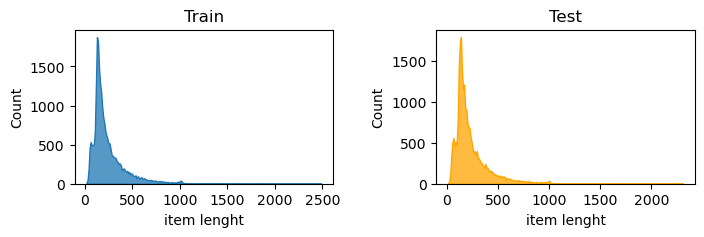

In [6]:
len_list_train = np.array([len(l) for l in train_data])
len_list_test = np.array([len(l) for l in test_data])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 2),
                               gridspec_kw={"wspace": 0.4, "hspace": 0.4})
sns.histplot(len_list_train, element="poly", ax=ax1)
sns.histplot(len_list_test, element="poly", color="orange", ax=ax2)

ax1.set_title("Train")
ax1.set_xlabel("item lenght")
ax2.set_title("Test")
ax2.set_xlabel("item lenght")

plt.show()

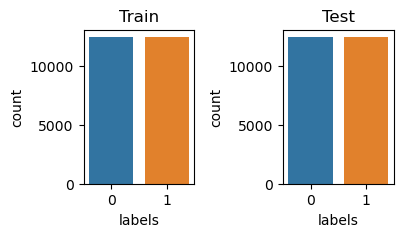

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(4, 2),
                               gridspec_kw={"wspace": 0.8, "hspace": 0.4})
sns.countplot(x=train_labels, ax=ax1)
sns.countplot(x=test_labels, ax=ax2)

ax1.set_title("Train")
ax1.set_xlabel("labels")
ax2.set_title("Test")
ax2.set_xlabel("labels")


plt.show()

In [8]:
maxlen = 300  # з першого графіку слідує що авторам рецензій в більшості випадків вистачає 300 слів щоб оцінити фільм.
max_features = 10000

In [9]:
input_train = pad_sequences(train_data, maxlen=maxlen)
input_test = pad_sequences(test_data, maxlen=maxlen)
imdb_data = InputData(input_train, train_labels, input_test.astype("int32"), test_labels.astype("int32"))

In [10]:
print(f"Train shape: {input_train.shape}")
print(f"Test shape: {input_test.shape}")

Train shape: (25000, 300)
Test shape: (25000, 300)


### __"Найнаївніша" RNN модель__ ###

In [12]:
rnn_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    SimpleRNN(16),
    Dense(1, activation="sigmoid"),
]
model = RnnModel(rnn_layers, HyperParameters())
model.summary(verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 16)           160000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160545 (627.13 KB)
Trainable params: 160545 (627.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


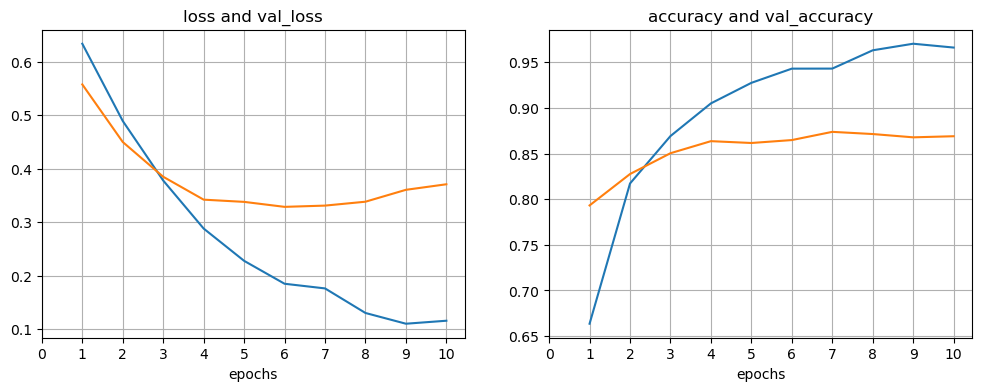

In [13]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/rnn_model",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=0)

model.fit(imdb_data, callbacks=[checkpoint_callback])
loss_accuracy_plotting(model.history)

In [14]:
model.model.load_weights("models/rnn_model")
model.evaluate(imdb_data)

Train loss: 0.190408393740654, train accuracy: 0.9398800134658813
Test loss:  0.3346099257469177, test accuracy:  0.8618800044059753

Train
Min loss : 0.11038768291473389, epoch num: 9
Max accuracy : 0.9703500270843506, epoch num: 9

Validation
Min loss : 0.32886573672294617, epoch num: 6
Max accuracy : 0.8737999796867371, epoch num: 7


__Без проблем отримуємо точність 0.8619__

### __Подивимось як модель тренується з 32 та 64 ядрами в RNN шарі__ ###

In [16]:
val_accurasy = {}
val_loss = {}

neurons_qty = [32, 64]

for qty in neurons_qty:
    rnn_layers = [
        Embedding(max_features, 16, input_length=maxlen),
        SimpleRNN(qty),
        Dense(1, activation="sigmoid"),
    ]
    model = RnnModel(rnn_layers, HyperParameters())
    model.fit(imdb_data)               
    val_accurasy[qty] = model.history["val_accuracy"]  
    val_loss[qty] = model.history["val_loss"]

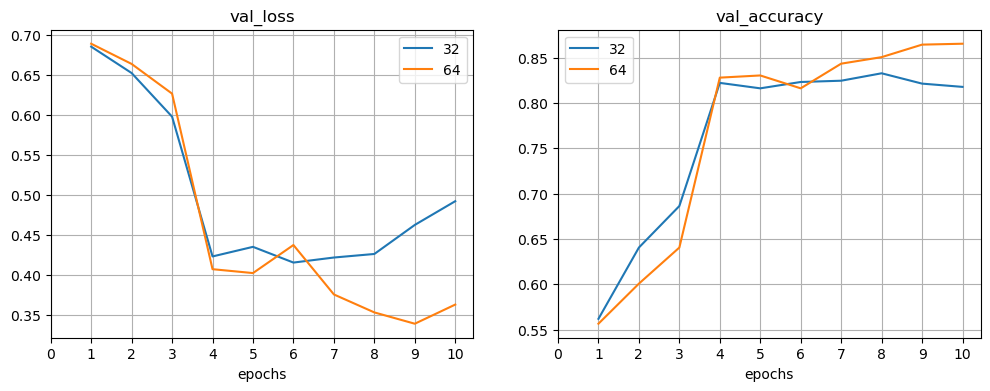

In [17]:
multi_val_loss_accuracy_plotting(val_loss, val_accurasy)

__64 ядра виглядають більш солідно__

### __Чи є залежність від довжини embed вектора__ ###

In [18]:
val_accurasy = {}
val_loss = {}

v_lenghts = [16, 32]

for len_ in v_lenghts:
    rnn_layers = [
        Embedding(max_features, len_, input_length=maxlen),
        SimpleRNN(64),
        Dense(1, activation="sigmoid"),
    ]
    model = RnnModel(rnn_layers, HyperParameters(n_epochs=8))
    model.fit(imdb_data)               
    val_accurasy[len_] = model.history["val_accuracy"]  
    val_loss[len_] = model.history["val_loss"]

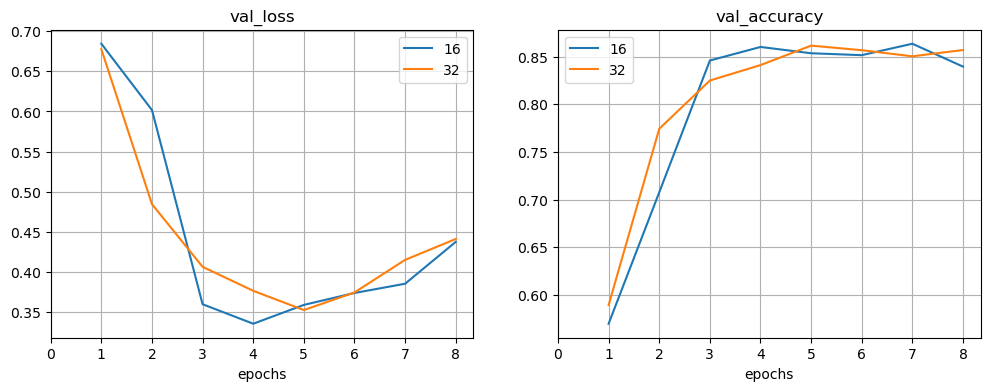

In [19]:
multi_val_loss_accuracy_plotting(val_loss, val_accurasy)

__з довжиною вектора 16 модель біль точніша, але й швидше перетреновується__

### __Нарешті настав час моїх улюблених дропаутів__ ###

In [22]:
val_accurasy = {}
val_loss = {}

dropouts = [0.6, 0.7, 0.8]

for dropout in dropouts:
    rnn_layers = [
        Embedding(max_features, 16, input_length=maxlen),
        SimpleRNN(64, dropout=dropout),
        Dense(1, activation="sigmoid"),
    ]
    model = RnnModel(rnn_layers, HyperParameters(n_epochs=15))
    model.fit(imdb_data)               
    val_accurasy[dropout] = model.history["val_accuracy"]  
    val_loss[dropout] = model.history["val_loss"]

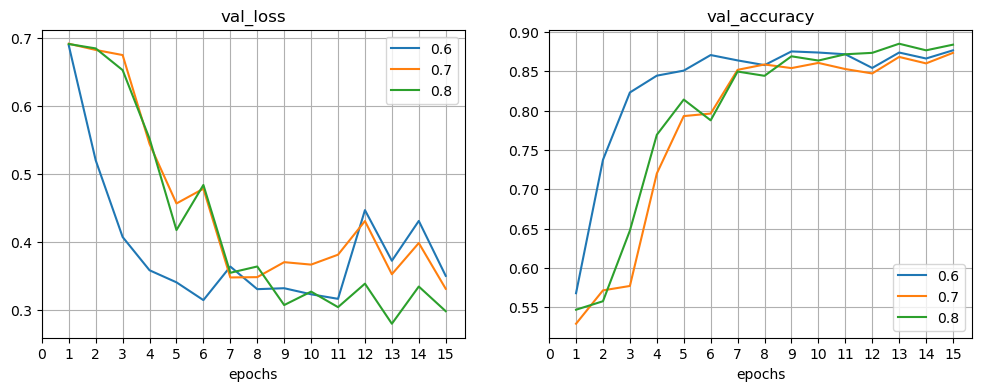

In [23]:
multi_val_loss_accuracy_plotting(val_loss, val_accurasy)

__Вибір начебто очевидний - 0.8__

### __Перевіряємо модель з вибранними параметрами__ ###

In [27]:
rnn_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    SimpleRNN(64, dropout=0.8),
    Dense(1, activation="sigmoid"),
]
model = RnnModel(rnn_layers, HyperParameters(n_epochs=15))
model.summary(verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 300, 16)           160000    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 64)                5184      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 165249 (645.50 KB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


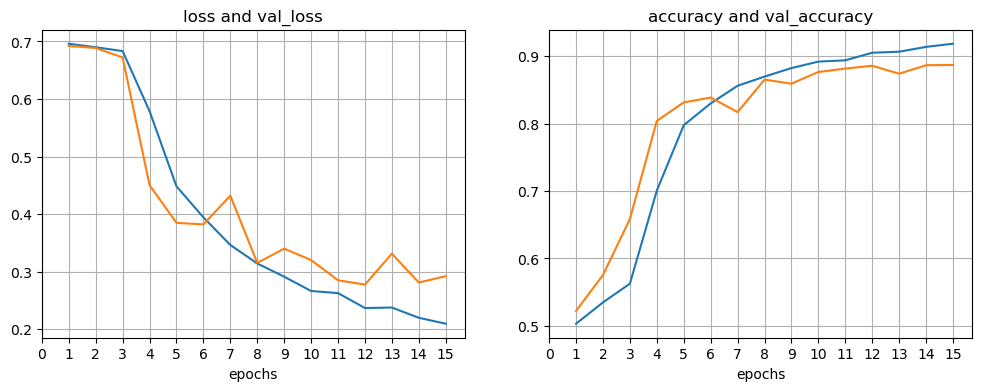

In [28]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/rnn_model",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=0)
model.fit(imdb_data, callbacks=[checkpoint_callback])
loss_accuracy_plotting(model.history)

In [29]:
model.model.load_weights("models/rnn_model")
model.evaluate(imdb_data)

Train loss: 0.1804356873035431, train accuracy: 0.9336400032043457
Test loss:  0.2866634726524353, test accuracy:  0.8810799717903137

Train
Min loss : 0.2095763236284256, epoch num: 15
Max accuracy : 0.9186999797821045, epoch num: 15

Validation
Min loss : 0.2775217592716217, epoch num: 12
Max accuracy : 0.8871999979019165, epoch num: 15


__З деякою вірогідністю ловимо нашу модель на val loss = 0.2775 та отримуємо точність на test - 0.8811, що на 1.9 відсотка краще за початкову конфігурацію.__

В дугій частині ДЗ візьмемо ці параметри за основу та подивимось як працюють з нашими данними моделі з іншими типами архітектур